In [1]:
# Load modules
import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import sys
import os
sys.path.append('..')
from types import SimpleNamespace
# from field_of_junctions import FieldOfJunctions
import nbimporter
import math

from torchsummary import summary

# from Dataset_Maker_Lines_and_Juncs import make_random_line_set, make_grey_transform_lines, make_random_junction_set, make_grey_transform_junc
from multijunction import MultiJunction

# %load_ext autoreload
# %reload_ext autoreload

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('LazyLinear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0) 
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(
            0)
    if classname.find('Conv2d') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

In [97]:
# Load dataset 

data_folder = 'foj_data/grayscale_junctions/'


# Start with purely junction images
# with open(data_folder + 'junction_data_24_10000_grey_multicolor_noiseless_centered.pkl','rb') as f:
# with open(data_folder + 'junction_data_24_20000_grey_multicolor_noiseless_centered.pkl','rb') as f:
with open(data_folder + 'junction_data_24_20000_grey_multicolor_noiseless_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']

In [98]:
# Create data structure with optional transforms

# params: theta1, theta2, theta3, x0, y0
class JunctionDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, params, boundaries, transform=None):
        self.images = images
        self.params = params
        self.boundaries = boundaries
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]

        if self.transform:
            image = self.transform(image)
            
        param = self.params[index,:]
        boundary = boundaries[index]

        return image, param, boundary

    def __len__(self):
        return len(self.images)

# # params: alpha, omega1, omega2, omega3, x0, y0

# class JunctionDataset(torch.utils.data.Dataset):
#     """ Dataset with support of transforms.
#     """

#     def __init__(self, images, params, boundaries, transform=None):
#         self.images = images
#         self.params = params
#         self.boundaries = boundaries
#         self.transform = transform

#     def __getitem__(self, index):
#         image = self.images[index]

#         if self.transform:
#             image = self.transform(image)
            
#         # Data generated as: theta1, theta2, theta3, u, v
#         # We want representation: alpha [orientation], omega1, omega2, omega3, u, v

#         jparam = self.params[index].squeeze()
#         center = jparam[3:]
#         angles_ord = torch.sort(jparam[:3])[0]
        
# #         print(angles_ord)

#         omega1 = angles_ord[1]-angles_ord[0]
#         omega2 = angles_ord[2]-angles_ord[1]
#         omega3 = 2*torch.pi - omega1 - omega2
        
#         angles = torch.tensor([angles_ord[0], omega1, omega2, omega3])
        
#         jparam_out = torch.cat((angles,center))

#         boundary = boundaries[index]

#         return image, jparam_out, boundary

#     def __len__(self):
#         return len(self.images)
    
    
# Make training and testing data
junc_data = JunctionDataset(wedges_grey, params, boundaries)#, transform=trainTransform)
data_size = len(junc_data)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(junc_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


# print(next(iter(train_loader)))


tensor([[[ 2.3250]],

        [[ 2.5548]],

        [[ 5.3818]],

        [[-0.0775]],

        [[-0.1255]]])


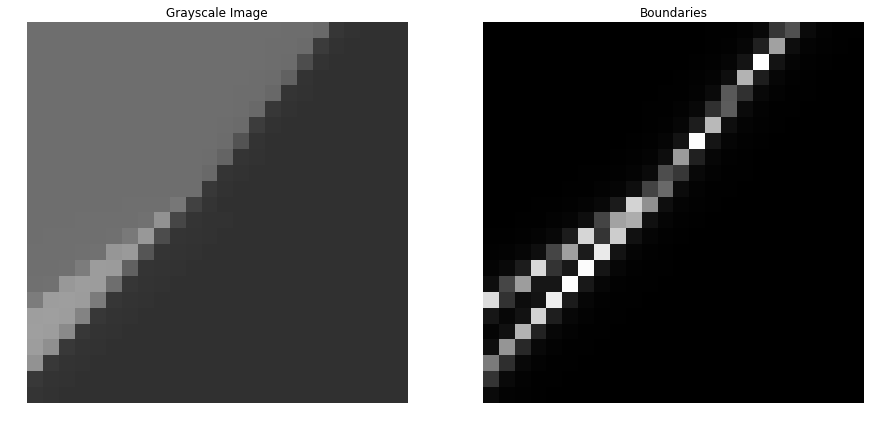

In [102]:
data = next(iter(test_loader))
wedge_image = data[0]
boundary_image = data[2]

print(data[1][0])


img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(121)
plt.imshow(wedge_image[0].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(122)
plt.imshow(boundary_image[0].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');



In [100]:
# Make Transformation matrix L

# Assume output of first network is 24 x 24
Wn,Hn = 20,20

# First define the center of the global coordinate system
xa,ya = torch.zeros((Wn,Hn),device=dev),torch.zeros((Wn,Hn),device=dev)

# First, let's make the transformation matrix:
y0, x0 = torch.meshgrid([torch.linspace(-1.0+4/24, 1.0-4/24, Wn, device=dev),
                               torch.linspace(-1.0+4/24, 1.0-4/24, Hn, device=dev)])

L = torch.zeros((1,3,3,Hn,Wn),device=dev)
L[:,0,0,:,:] = 1
L[:,1,1,:,:] = 1
L[:,2,2,:,:] = 1
L[:,0,2,:,:] = -x0+xa
L[:,1,2,:,:] = -y0+ya


Linv = torch.zeros_like(L)
for ii in range(L.shape[3]):
    for jj in range(L.shape[4]):
        Linv[0,:,:,ii,jj] = torch.inverse(L[0,:,:,ii,jj])

# L transforms line parameters for patches into the global coordinate system
# Linv transforms global line parameters into patch line parameters

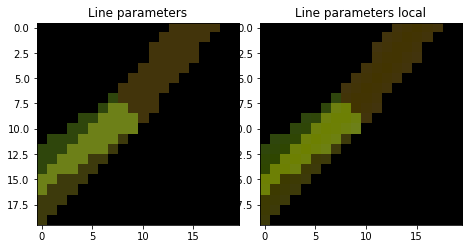

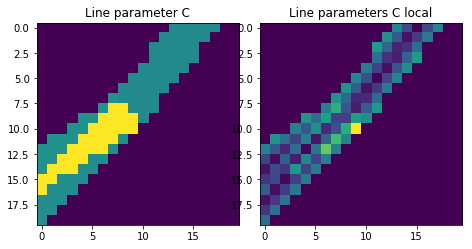

In [103]:
# Given a set of line parameters, construct the ground truth:
def make_ground_truth(params,Linv,H,rf,x0,y0):
    
        theta = params[:,:3].unsqueeze(2).unsqueeze(3)
        cx = params[:,3]
        cy = params[:,4]
        
        a = -torch.sin(theta)
        b = torch.cos(theta)
        c = torch.sin(theta)*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - torch.cos(theta)*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3)

        # radius threshold 
        r = rf/2*.8/H # divide the receptive field by 2, multiply by a factor .8 (because we want enough of the line to be included), and then scale by the size of the original (not cropped) image

        mask1 = (torch.abs(a*x0.unsqueeze(0).unsqueeze(1) + b*y0.unsqueeze(0).unsqueeze(1) + c)<r)
        mask2 = (b*x0.unsqueeze(0).unsqueeze(1) - a*y0.unsqueeze(0).unsqueeze(1) > b*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - a*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3) )

        full_mask = mask1*mask2
        full_mask = full_mask/torch.max(full_mask.view(params.shape[0],-1,3),1)[0].unsqueeze(2).unsqueeze(3)

        global_line_params = torch.stack((a,b,c),dim=4)
        
        ground_truth_global = torch.mean(global_line_params*(full_mask.unsqueeze(4)),1)#(line_params*(full_mask.unsqueeze(4))).sum(1)
        ground_truth_local = torch.einsum('ajbc,ajkbc->akbc',ground_truth_global.permute(0,3,1,2),Linv).permute(0,2,3,1)
        
        return ground_truth_global,ground_truth_local

# def make_ground_truth(params,Linv,H,rf,x0,y0):
    
# #         theta = params[:,:3].unsqueeze(2).unsqueeze(3)
        
#         theta1 = params[:,0]
#         theta2 = params[:,0] + params[:,1]
#         theta3 = params[:,0] + params[:,1] + params[:,2]
        
#         theta = torch.stack((theta1,theta2,theta3),axis=1).unsqueeze(2).unsqueeze(3)
#         cx = params[:,4]
#         cy = params[:,5]
        
#         a = -torch.sin(theta)
#         b = torch.cos(theta)
#         c = torch.sin(theta)*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - torch.cos(theta)*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3)

#         # radius threshold 
#         r = rf/2*.8/H # divide the receptive field by 2, multiply by a factor .8 (because we want enough of the line to be included), and then scale by the size of the original (not cropped) image

#         mask1 = (torch.abs(a*x0.unsqueeze(0).unsqueeze(1) + b*y0.unsqueeze(0).unsqueeze(1) + c)<r)
#         mask2 = (b*x0.unsqueeze(0).unsqueeze(1) - a*y0.unsqueeze(0).unsqueeze(1) > b*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - a*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3) )

#         full_mask = mask1*mask2
#         full_mask = full_mask/torch.max(full_mask.view(params.shape[0],-1,3),1)[0].unsqueeze(2).unsqueeze(3)

#         global_line_params = torch.stack((a,b,c),dim=4)
        
#         ground_truth_global = torch.mean(global_line_params*(full_mask.unsqueeze(4)),1)#(line_params*(full_mask.unsqueeze(4))).sum(1)
#         ground_truth_local = torch.einsum('ajbc,ajkbc->akbc',ground_truth_global.permute(0,3,1,2),Linv).permute(0,2,3,1)
        
#         return ground_truth_global,ground_truth_local
    

data = next(iter(test_loader))
gt_line_params = data[1].to(dev)

gt, gt_local = make_ground_truth(gt_line_params[0,:].squeeze().unsqueeze(0),Linv,24,10,x0,y0)

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(torch.abs(gt[0].cpu()))
plt.title('Line parameters')
plt.subplot(222)
plt.imshow(torch.abs(gt_local[0].cpu()))
plt.title('Line parameters local')
plt.subplots_adjust(wspace=0, hspace=.15)

# For visualization purposes:
# Slopes (a/b) are the same, but c is different for local vs global
# SANITY CHECK: c is zero because all the lines go through the center

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(torch.abs(gt[0,:,:,2].cpu()))
plt.title('Line parameter C')
plt.subplot(222)
plt.imshow(torch.abs(gt_local[0,:,:,2].cpu()))
plt.title('Line parameters C local')
plt.subplots_adjust(wspace=0, hspace=.15)

In [48]:
# opts = SimpleNamespace()
# opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
# opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
# opts.patchres                 =  50    # Number of pixels in each dimension of square patch
# opts.delta                    =  .2   # Dirac delta relaxation parameter for rendering boundary maps


# b_gt = MultiJunction(3, dev, gt_line_params[:,:3], gt_line_params[:,0], gt_line_params[:,1:4]).render_boundaries(opts,dev).to(dev) 

# plt.figure()
# plt.imshow(b_gt.cpu()[0])

In [104]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2) #64 is good
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2)
        self.fc = nn.LazyLinear(3)
        self.activate = nn.ReLU()
#         self.avgpool = nn.AvgPool2d(2, stride=1)
#         self.batchnorm = nn.LazyBatchNorm1d()
    
    def forward(self, x):

#         x = self.batchnorm(x)
        x = self.conv1(x)
#         x = self.batchnorm(x)
        x = self.activate(x)
#         x = self.avgpool(x)
        x = self.conv2(x)
#         x = self.batchnorm(x)
        x = self.activate(x)
        x = self.conv3(x)
#         x = self.batchnorm(x)
        x = self.activate(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
H,W = 5,5
line_model = offCenterLineNet()
line_model = line_model.to(dev)
line_model.load_state_dict(torch.load('model_weights/line_network_noiseless_with_empty_patches.pt'));
summary(line_model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 16, 4, 4]              80
              ReLU-2             [-1, 16, 4, 4]               0
            Conv2d-3             [-1, 16, 2, 2]           2,320
              ReLU-4             [-1, 16, 2, 2]               0
            Conv2d-5             [-1, 32, 1, 1]           2,080
              ReLU-6             [-1, 32, 1, 1]               0
            Linear-7                    [-1, 3]              99
Total params: 4,579
Trainable params: 4,579
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [105]:
class offCenterLineNetBig(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2) #64 is good
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2)
        self.conv4 = nn.Conv2d(32, 3, kernel_size=1)
#         self.avgpool = nn.AvgPool2d(2)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):
        
#         mean, std = torch.mean(x), torch.std(x)
#         x  = (x-mean)/std
        
        x = self.conv1(x)
        x = self.activate(x)
        x = self.conv2(x)
        x = self.activate(x)
        x = self.conv3(x)
        x = self.activate(x)
        x = self.conv4(x)
        
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2,:,:],p=2,dim=1)).unsqueeze(1)    
        out = x/(norm_factor)#+eps)
        
        return out
    
R = 24 

big_model = offCenterLineNetBig()
big_model = big_model.to(dev)
summary(big_model, input_size=(1, R, R))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 23, 23]              80
              ReLU-2           [-1, 16, 23, 23]               0
            Conv2d-3           [-1, 16, 21, 21]           2,320
              ReLU-4           [-1, 16, 21, 21]               0
            Conv2d-5           [-1, 32, 20, 20]           2,080
              ReLU-6           [-1, 32, 20, 20]               0
            Conv2d-7            [-1, 3, 20, 20]              99
Total params: 4,579
Trainable params: 4,579
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 0.02
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


In [106]:
# First load the line network:
big_model = offCenterLineNetBig();
big_model = big_model.to(dev)

offCenterLineNetWeights = line_model.state_dict();
offCenterLineNetWeightsBig = big_model.state_dict();

with torch.no_grad():
    big_model.conv1.weight.copy_(offCenterLineNetWeights['conv1.weight'])
    big_model.conv1.bias.copy_(offCenterLineNetWeights['conv1.bias'])
    big_model.conv2.weight.copy_(offCenterLineNetWeights['conv2.weight'])
    big_model.conv2.bias.copy_(offCenterLineNetWeights['conv2.bias'])
    big_model.conv3.weight.copy_(offCenterLineNetWeights['conv3.weight'])
    big_model.conv3.bias.copy_(offCenterLineNetWeights['conv3.bias'])
    big_model.conv4.weight.copy_(offCenterLineNetWeights['fc.weight'].view(offCenterLineNetWeightsBig['conv4.weight'].shape))
    big_model.conv4.bias.copy_(offCenterLineNetWeights['fc.bias'])
    
big_model.eval();


In [110]:
# Predict sin & cos of 3 lines

class lineToJunctionNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(20, 8, kernel_size=3)
#         self.conv3 = nn.Conv2d(6, 6, kernel_size=3)
        self.fc1 = nn.LazyLinear(8)
        self.fc2 = nn.LazyLinear(8)
        self.activate = nn.ReLU()
        self.tanH = nn.Tanh()
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.activate(x)
        x = self.conv2(x)
        x = self.activate(x)
#         x = self.conv3(x)
#         x = self.activate(x)
#         print(x.shape)
        x = x.reshape(x.shape[0],-1)
#         print(x.shape)
        x = self.fc1(x)
        x = self.fc2(x)

        # The network will output 8 values:
        # c(theta1), c(theta1), c(theta2), s(theta2), c(theta3), s(theta3), u, v

#       First, use sigmoid to ensure first 6 outputs lie between -1 and 1
        x_norm = self.tanH(x[:,:6])
        
#       Next, normalize s/c(theta1), s/c(theta2), s/c(theta3)
        
#         theta1_norm = torch.norm(x_norm[:,:2],dim=1).unsqueeze(1)
#         theta2_norm = torch.norm(x_norm[:,2:4],dim=1).unsqueeze(1)
#         theta3_norm = torch.norm(x_norm[:,4:6],dim=1).unsqueeze(1)

#         out1 = x_norm[:,:2]/theta1_norm
#         out2 = x_norm[:,2:4]/theta2_norm
#         out3 = x_norm[:,4:6]/theta3_norm
        
#         out = torch.cat((out1,out2,out3,x[:,6:]),dim=1)

        x_temp = x[:,:6].reshape(-1,2,3)
        x_temp = (x_temp/(torch.norm(x_temp,p=2,dim=1)).unsqueeze(1).repeat(1,2,1)).flatten(1)
        
        out = torch.cat((x_temp,x[:,6:]),axis=1)

        return out
    
R = 24

junction_model = lineToJunctionNet()
junction_model = junction_model.to(dev)
summary(junction_model, input_size=(3, R, R))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 22, 22]             560
              ReLU-2           [-1, 20, 22, 22]               0
            Conv2d-3            [-1, 8, 20, 20]           1,448
              ReLU-4            [-1, 8, 20, 20]               0
            Linear-5                    [-1, 8]          25,608
            Linear-6                    [-1, 8]              72
              Tanh-7                    [-1, 6]               0
Total params: 27,688
Trainable params: 27,688
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.20
Params size (MB): 0.11
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 62343.03480799058, Avg. Test Loss: 1533.5087890625
Epoch: 2, Avg. Train Loss: 361.98060080584355, Avg. Test Loss: 41.339073181152344
Epoch: 3, Avg. Train Loss: 21.641835675520056, Avg. Test Loss: 3.88826847076416
Epoch: 4, Avg. Train Loss: 1.932694088010227, Avg. Test Loss: 1.3231886625289917
Epoch: 5, Avg. Train Loss: 1.149137053419562, Avg. Test Loss: 0.9462698698043823
Epoch: 6, Avg. Train Loss: 0.8817072019857519, Avg. Test Loss: 0.7732229232788086
Epoch: 7, Avg. Train Loss: 0.7380752212861005, Avg. Test Loss: 0.676630437374115
Epoch: 8, Avg. Train Loss: 0.6522204665576711, Avg. Test Loss: 0.6144222617149353
Epoch: 9, Avg. Train Loss: 0.6010809488156262, Avg. Test Loss: 0.5740121603012085
Epoch: 10, Avg. Train Loss: 0.5642537895370933, Avg. Test Loss: 0.5435608625411987
Epoch: 11, Avg. Train Loss: 0.5386613519752727, Avg. Test Loss: 0.5231897234916687
Epoch: 12, Avg. Train Loss: 0.5183266769437229, Avg. Test Loss: 0.5026659965515137
Epoch: 13, Avg. Train 

Epoch: 99, Avg. Train Loss: 0.2463667318224907, Avg. Test Loss: 0.22815793752670288
Epoch: 100, Avg. Train Loss: 0.23369490705868778, Avg. Test Loss: 0.23662704229354858
Epoch: 101, Avg. Train Loss: 0.23807418302578084, Avg. Test Loss: 0.2206285446882248
Epoch: 102, Avg. Train Loss: 0.2755492886199671, Avg. Test Loss: 0.2265029400587082
Epoch: 103, Avg. Train Loss: 0.2306586587253739, Avg. Test Loss: 0.21674194931983948
Epoch: 104, Avg. Train Loss: 0.23332111756591237, Avg. Test Loss: 0.31073832511901855
Epoch: 105, Avg. Train Loss: 0.23314571687403848, Avg. Test Loss: 0.22936585545539856
Epoch: 106, Avg. Train Loss: 0.21902301293962143, Avg. Test Loss: 0.21289542317390442
Epoch: 107, Avg. Train Loss: 0.22764319312923095, Avg. Test Loss: 0.21287116408348083
Epoch: 108, Avg. Train Loss: 0.23904455102541866, Avg. Test Loss: 0.2835018038749695
Epoch: 109, Avg. Train Loss: 0.385886306710103, Avg. Test Loss: 0.227409228682518
Epoch: 110, Avg. Train Loss: 0.2210875210516593, Avg. Test Loss: 

Epoch: 196, Avg. Train Loss: 0.1916632214013268, Avg. Test Loss: 0.20296548306941986
Epoch: 197, Avg. Train Loss: 0.18996737283818863, Avg. Test Loss: 0.1694633662700653
Epoch: 198, Avg. Train Loss: 0.16449838613762574, Avg. Test Loss: 0.15669414401054382
Epoch: 199, Avg. Train Loss: 0.15490328608190312, Avg. Test Loss: 0.1574363112449646
Epoch: 200, Avg. Train Loss: 0.1603974362506586, Avg. Test Loss: 0.15927395224571228
Epoch: 201, Avg. Train Loss: 0.15307789164430954, Avg. Test Loss: 0.14834001660346985
Epoch: 202, Avg. Train Loss: 0.15005726849331574, Avg. Test Loss: 0.1485966593027115
Epoch: 203, Avg. Train Loss: 0.15682372144039938, Avg. Test Loss: 0.14821267127990723
Epoch: 204, Avg. Train Loss: 0.1553247570991516, Avg. Test Loss: 0.1613255739212036
Epoch: 205, Avg. Train Loss: 0.15661427904577815, Avg. Test Loss: 0.15366995334625244
Epoch: 206, Avg. Train Loss: 0.15768553097458446, Avg. Test Loss: 0.1501481533050537
Epoch: 207, Avg. Train Loss: 0.1506124388645677, Avg. Test Los

Epoch: 292, Avg. Train Loss: 0.11329449603662771, Avg. Test Loss: 0.11806128919124603
Epoch: 293, Avg. Train Loss: 0.11345868645345464, Avg. Test Loss: 0.11187978088855743
Epoch: 294, Avg. Train Loss: 0.11953312925556127, Avg. Test Loss: 0.1282108724117279
Epoch: 295, Avg. Train Loss: 0.11641287233899622, Avg. Test Loss: 0.1199546754360199
Epoch: 296, Avg. Train Loss: 0.1135285244706799, Avg. Test Loss: 0.12048809975385666
Epoch: 297, Avg. Train Loss: 0.1128002256155014, Avg. Test Loss: 0.12344267219305038
Epoch: 298, Avg. Train Loss: 0.11390223595149376, Avg. Test Loss: 0.10911417007446289
Epoch: 299, Avg. Train Loss: 0.10890171830268468, Avg. Test Loss: 0.1094522699713707
Epoch: 300, Avg. Train Loss: 0.11165192065870061, Avg. Test Loss: 0.12301038205623627
Finished Training


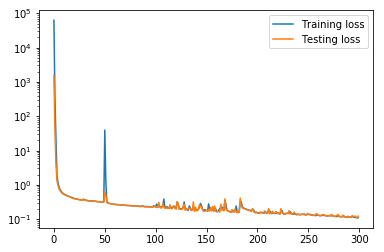

In [115]:
# Now let's train the initial network 

model = lineToJunctionNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 300

mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
ce_loss = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss() #nn.functional.binary_cross_entropy_with_logits()
mlsm_loss = nn.MultiLabelSoftMarginLoss()

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .1   # Dirac delta relaxation parameter for rendering boundary maps

 
def get_loss(output_line_params, output_gt):
    
        
        angle_params = torch.cat((torch.cos(output_gt[:,:3]),torch.sin(output_gt[:,:3])),axis=1)
        
        loss = mse_loss(output_line_params[:,6:],output_gt[:,3:]) + mae_loss(output_line_params[:,:6],angle_params) 
        
        return loss

def forward_pass(data, opts, training):
    
    # Load inputs from data
    inputs, output_gt, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()

#     # Interpret inputs as their ground truth
    gt, _ = make_ground_truth(output_gt.squeeze(),Linv,24,10,x0,y0)
    new_inputs = gt.permute(0,3,1,2)
#     line_params = big_model(inputs)  
#     new_inputs = torch.einsum('ajbc,ajkbc->akbc',line_params,L)
    
    # forward pass to get outputs
    output_line_params = model(new_inputs)
        
    loss = get_loss(output_line_params,output_gt.squeeze())
#     loss, angles_gt_oh = (output_line_params,output_gt, opts)

    if training:

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()
        
    return output_line_params, loss#, angles_gt_oh
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 50:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    model.train();
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        _,loss = forward_pass(data, opts, training = 1)

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1    

            _,loss = forward_pass(data, opts, training = 0)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)

    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

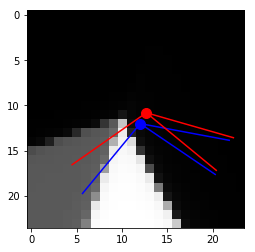

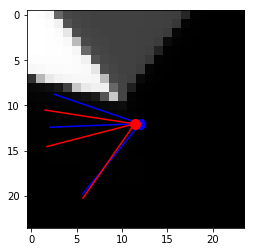

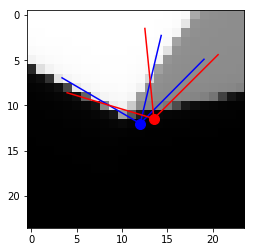

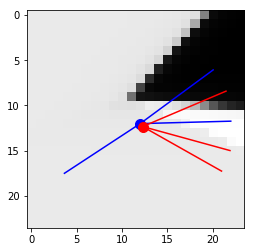

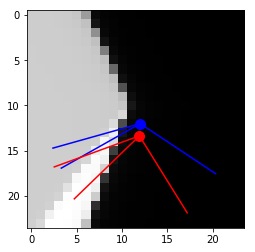

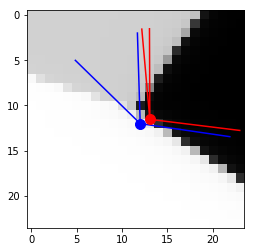

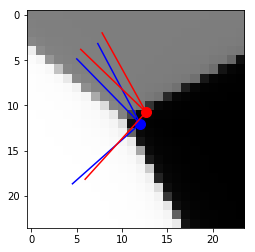

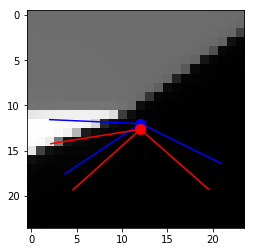

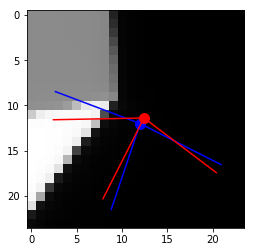

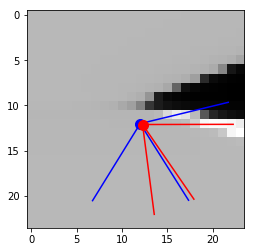

In [116]:
# What do the outputs look like? 

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _ = data
    
    inputs, output_gt = inputs.to(dev), labels.to(dev)
    
    gt_lines, _ = make_ground_truth(output_gt.squeeze(),Linv,24,10,x0,y0)
    new_inputs = gt_lines.permute(0,3,1,2)
    
    # forward pass to get outputs
    outputs = model(new_inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
for ii in range(10):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray')

    center_gt = gt[ii][3:]*12 + 12

    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    
    line1_end = (center_gt + 10*np.array([np.cos(gt[ii][0]),np.sin(gt[ii][0])]))
    line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_gt + 10*np.array([np.cos(gt[ii][1]),np.sin(gt[ii][1])]))
    line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_gt + 10*np.array([np.cos(gt[ii][2]),np.sin(gt[ii][2])]))
    line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-b')
    plt.plot(line2[0,:],line2[1,:],'-b')
    plt.plot(line3[0,:],line3[1,:],'-b')
    
    
    center_output = outputs[ii,6:].detach().cpu()*12+12
    
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    line1_end = (center_output + 10*np.array([outputs[ii][0],outputs[ii][3]]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + 10*np.array([outputs[ii][1],outputs[ii][4]]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + 10*np.array([outputs[ii][2],outputs[ii][5]]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')



In [ ]:
# Now let's train the initial network 

model = lineToJunctionNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 300

mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
ce_loss = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss() #nn.functional.binary_cross_entropy_with_logits()
mlsm_loss = nn.MultiLabelSoftMarginLoss()

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .1   # Dirac delta relaxation parameter for rendering boundary maps


def boundary_loss(output_line_params, output_gt, opts, dev):
        
        # First deal with ground truth, which is represented as M-junctions
        b_gt = MultiJunction(3, dev, output_gt[:,4:], output_gt[:,0], output_gt[:,1:4]).render_boundaries(opts,dev).to(dev) 

        # Next deal with the output of the network
        # Convert output into format accepted by MultiJunction
        angles,_ = torch.sort(torch.stack((torch.atan2(output_line_params[:,1],output_line_params[:,0]),\
                               torch.atan2(output_line_params[:,3],output_line_params[:,2]),\
                              torch.atan2(output_line_params[:,5],output_line_params[:,4])),axis=1),axis=1)
        
        
        
        alpha_out = angles[:,0]
        omega1_out = angles[:,1] - alpha_out
        omega2_out = angles[:,2] - omega1_out
        omega3_out = 2*torch.pi - omega1_out - omega2_out
        omega_all_out = torch.cat((omega1_out.unsqueeze(1),omega2_out.unsqueeze(1),omega3_out.unsqueeze(1)),dim=1)
        
        jn = MultiJunction(3, dev, output_line_params[:,6:], alpha_out, omega_all_out)
#         jn = MultiJunction(3, dev, torch.zeros((output_line_params.shape[0],2),device=dev), alpha_out, omega_all_out)
        b = jn.render_boundaries(opts,dev)
            
        loss = mse_loss(b,b_gt) + .05*torch.mean(torch.norm(output_line_params[:,6:],dim=1))
    
        return loss, b, b_gt
    
    
def cross_entropy_loss(output_line_params, output_gt, opts):
            
        # Calculate the ground truth angles
#         angles = torch.round(torch.rad2deg(output_gt[:,:3]))
#         angles = (angles + 360) % 360

        # Convert to a one hot encoding
        angles_gt_oh = F.one_hot(angles[:,0].long(), num_classes=360) \
            + F.one_hot(angles[:,1].long(), num_classes=360) \
            + F.one_hot(angles[:,2].long(), num_classes=360)
        
#         loss = bce_loss(output_line_params,angles_gt_oh.double())
        loss = mlsm_loss(output_line_params,angles_gt_oh.double())
    
        return loss, angles_gt_oh

def forward_pass(data, opts, training):
    
    # Load inputs from data
    inputs, output_gt, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()

#     # Interpret inputs as their ground truth
#     gt, _ = make_ground_truth(output_gt.squeeze(),Linv,24,10,x0,y0)
#     new_inputs = gt.permute(0,3,1,2)
    line_params = big_model(inputs)
    
    new_inputs = torch.einsum('ajbc,ajkbc->akbc',line_params,L)
    
#     p_enc_2d = PositionalEncodingPermute2D(1)
    
#     pos_enc = p_enc_2d(torch.zeros_like(new_inputs))
    
#     new_inputs = torch.cat((new_inputs,pos_enc[:,0:1,:,:]),axis=1)
#     new_inputs = p_enc_2d(new_inputs)
    # forward pass to get outputs
    output_line_params = model(new_inputs)
    
    loss,_,_ = boundary_loss(output_line_params,output_gt, opts, dev)
#     loss, angles_gt_oh = (output_line_params,output_gt, opts)

    if training:

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()
        
    return output_line_params, loss#, angles_gt_oh
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 50:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    model.train();
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        _,loss = forward_pass(data, opts, training = 1)

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1    

            _,loss = forward_pass(data, opts, training = 0)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)

    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

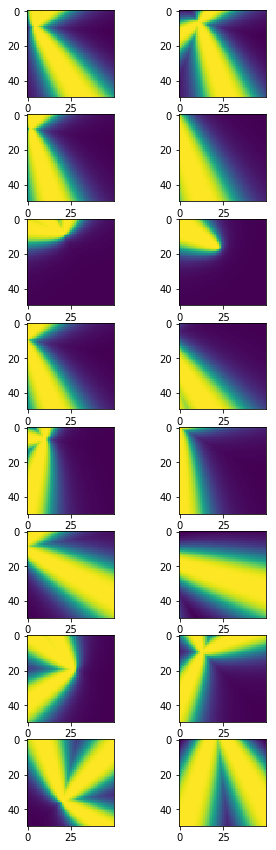

In [72]:
# Visualize the output of the network for boundary loss

data = next(iter(test_loader))

# Find output of the network 
output_line_params,output_loss = forward_pass(data, opts, training = 0)

gt_line_params = data[1].to(dev)

# print(output_line_params[0])

# print(output_line_params[:5,:])

loss, b, b_gt = boundary_loss(output_line_params, gt_line_params, opts, dev)

plt.figure(figsize=[5,15])

num_plot = 8


for ii in range(num_plot):
    
    plt.subplot(num_plot,2,2*ii+1)
    plt.imshow(b[ii].cpu().detach())
    plt.subplot(num_plot,2,2*ii+2)
    plt.imshow(b_gt[ii].cpu())

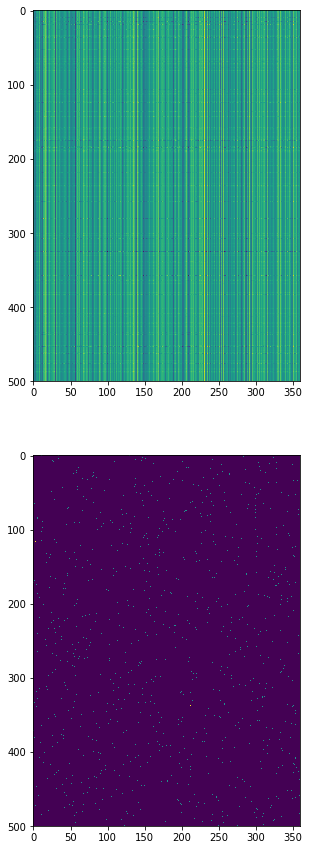

In [130]:
# Visualize the output of the network for cross entropy loss

data = next(iter(test_loader))

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .05   # Dirac delta relaxation parameter for rendering boundary maps

# Find output of the network 
output_line_params,output_loss,angles_gt_oh = forward_pass(data, opts, training = 0)

plt.figure(figsize=(15,15))
plt.subplot(211)
plt.imshow(output_line_params.cpu().detach())
plt.subplot(212)
plt.imshow(angles_gt_oh.cpu().detach().squeeze())

# gt_line_params = data[1].to(dev)

# print(output_line_params[0])

# # print(output_line_params[:5,:])

# b, b_gt,_ = boundary_loss(output_line_params, gt_line_params, opts)

# # print(b.shape,b_gt.shape)

# plt.figure(figsize=[5,15])

# num_plot = 8

# for ii in range(num_plot):
    
#     plt.subplot(num_plot,2,2*ii+1)
#     plt.imshow(b[ii].cpu().detach())
#     plt.subplot(num_plot,2,2*ii+2)
#     plt.imshow(b_gt[ii].cpu())

In [ ]:
# def network_loss(output_line_params, output_gt, opts):

    
# #         jn_gt = jn_gt = MultiJunction(3, dev, output_gt[:,4:], output_gt[:,0], output_gt[:,1:4])
# #         b_gt = jn_gt.render_boundaries(opts).to(dev)
        
#         # Convert gt into output format:
#         # Gt junction parameters:
#         # alpha, omega1, omega2, omega3, u, v
#         # c(theta1), s(theta1), c(theta2), s(theta2), c(theta3), s(theta3), u, v
#         # c(theta1) = torch.cos(alpha)
#         # s(theta1) = torch.sin(alpha)
#         # c(theta2) = torch.cos(alpha + omega1)
#         # s(theta2) = torch.sin(alpha + omega1)
#         # c(theta3) = torch.cos(alpha + omega1 + omega2)
#         # s(theta2) = torch.sin(alpha + omega1 + omega2)
        
#         ct1 = torch.cos(output_gt[:,0]).unsqueeze(1)
#         st1 = torch.sin(output_gt[:,0]).unsqueeze(1)
#         ct2 = torch.cos(output_gt[:,0] + output_gt[:,1]).unsqueeze(1)
#         st2 = torch.sin(output_gt[:,0] + output_gt[:,1]).unsqueeze(1)
#         ct3 = torch.cos(output_gt[:,0] + output_gt[:,2]).unsqueeze(1)
#         st3 = torch.sin(output_gt[:,0] + output_gt[:,2]).unsqueeze(1)
#         u = output_gt[:,4].unsqueeze(1)
#         v = output_gt[:,5].unsqueeze(1)
        
#         gt_reformat = torch.cat((ct1,st1,ct2,st2,ct3,st3,u,v),dim=1)
        
#         loss = mse_loss(output_line_params,gt_reformat)
#         # Output junction parameters:
#         # c(theta1), c(theta1), c(theta2), s(theta2), c(theta3), s(theta3), u, v
#         # Convert to:
#         # alpha, omega1, omega2, omega3, u, v
        
#         # alpha = atan2(s(theta1),c(theta1))
#         # omega1 = atan2(s(theta2),c(theta2)) - alpha
#         # omega2 = atan2(s(theta3),c(theta3)) - omega1
#         # omega3 = 2*pi - omega1 - omega2
        
# #         print(output_line_params.shape)
        
# #         alpha_out = torch.atan2(output_line_params[:,1],output_line_params[:,0])
# #         omega1_out = torch.atan2(output_line_params[:,3],output_line_params[:,2]) - alpha_out
# #         omega2_out = torch.atan2(output_line_params[:,5],output_line_params[:,4]) - omega1_out
# #         omega3_out = 2*torch.pi - omega1_out - omega2_out
        
# #         omega_all_out = torch.cat((omega1_out.unsqueeze(1),omega2_out.unsqueeze(1),omega3_out.unsqueeze(1)),dim=1)
        
# #         jn = MultiJunction(3, dev, output_line_params[:,6:], alpha_out, output_line_params[:,2:5])
# #         jn = MultiJunction(3, dev, torch.zeros((output_line_params.shape[0],2),device=dev), alpha_out, omega_all_out)
# #         b = jn.render_boundaries(opts)
                
# #         loss = mse_loss(b,b_gt) #+ .1*torch.mean(torch.norm(output_line_params[:,5:],dim=1))
    
#         return b, b_gt, loss


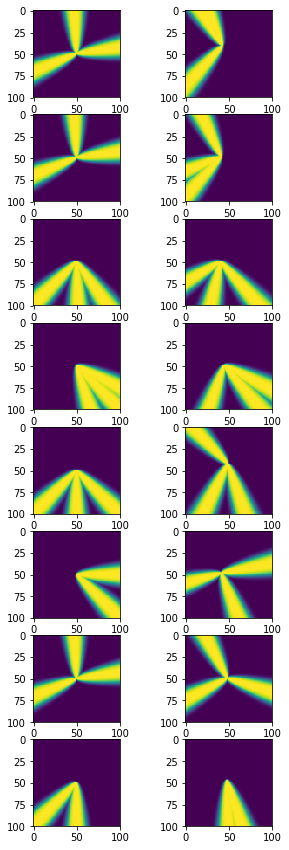

In [585]:
data = next(iter(test_loader))

# Find output of the network 
output_line_params,output_loss = forward_pass(data, opts, training = 0)

gt_line_params = data[1].to(dev)

# print(output_line_params[:5,:])

b, b_gt,_ = network_loss(output_line_params, gt_line_params, opts)

# print(b.shape,b_gt.shape)

plt.figure(figsize=[5,15])

num_plot = 8

for ii in range(num_plot):
    
    plt.subplot(num_plot,2,2*ii+1)
    plt.imshow(b[ii].cpu().detach())
    plt.subplot(num_plot,2,2*ii+2)
    plt.imshow(b_gt[ii].cpu())

In [ ]:
# Visualize variance

ker_size = 3

running_var = F.avg_pool2d(output_line_angles.unsqueeze(0)**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_angles.unsqueeze(0), kernel_size=ker_size,stride=1)**2

ker_size = 4

running_var_2 = F.avg_pool2d(output_line_angles.unsqueeze(0)**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_angles.unsqueeze(0), kernel_size=ker_size,stride=1)**2

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(running_var.squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(running_var_2.squeeze())
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure(figsize=[15,15])
plt.subplot(121)

low_var = running_var.squeeze()<100
low_var_2 = running_var_2.squeeze()<100

plt.imshow(low_var)
plt.subplot(122)
plt.imshow(low_var_2)
# plt.colorbar()

# Visualize variance

ker_size = 3

running_var = F.avg_pool2d(output_line_params_T**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_params_T, kernel_size=ker_size,stride=1)**2
m = nn.Threshold(1, 1)

print(running_var.shape)


plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(running_var.squeeze().permute(1,2,0))
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(np.clip(torch.linalg.norm(running_var.squeeze().permute(1,2,0),dim=2),0,1))
plt.colorbar(fraction=0.046, pad=0.04)

# plt.figure(figsize=[15,15])
# plt.subplot(131)
# plt.imshow(running_var.squeeze()[0])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(132)
# plt.imshow(running_var.squeeze()[1])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(133)
# plt.imshow(m(running_var.squeeze()[2]))
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.subplot(122)
# plt.imshow(running_var_2.squeeze())
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.subplot(122)
# low_var = running_var.squeeze()<500

# plt.imshow(low_var.permute(1,2,0))

